# FaceMask Detection

The dataset used for this project can be found on [Kaggle](https://www.kaggle.com/datasets/omkargurav/face-mask-dataset). It was downloaded as a ZIP file and extracted onto the local machine using the `extractall()` method from Python's `zipfile` library, as shown below:

In [1]:
# import zipfile

# zip_path = "D:/ProgressSoftExam/DataSets/FaceMaskDataSet/archive.zip"
# dataset_path = "C:/ProgressSoftTaks/DataSets/FaceMaskDataSet/facemask"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(dataset_path)

In [2]:
import os
import pandas as pd

# Paths to directories
data_dir = 'C:/ProgressSoftTaks/DataSets/FaceMaskDataSet/facemask/data'
with_mask_dir = os.path.join(data_dir, 'with_mask')
without_mask_dir = os.path.join(data_dir, 'without_mask')

# Create a dataframe
def create_mask_dataframe(with_mask_dir, without_mask_dir):
    data = {'filename': [], 'label': []}

    # Add with_mask images
    for filename in os.listdir(with_mask_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            data['filename'].append(os.path.join(with_mask_dir, filename))
            data['label'].append('0')  # 0 = with_mask

    # Add without_mask images
    for filename in os.listdir(without_mask_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            data['filename'].append(os.path.join(without_mask_dir, filename))
            data['label'].append('1')  # 1 = without_mask

    return pd.DataFrame(data)

# Generate the dataframe
df = create_mask_dataframe(with_mask_dir, without_mask_dir)


In [3]:
from sklearn.model_selection import train_test_split

# Split the data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=False)

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")


Train set: 5287 images
Validation set: 1133 images
Test set: 1133 images


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test DataGenerator without augmentation
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Flow from DataFrame for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'  # Binary classification
)

# Flow from DataFrame for validation
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Flow from DataFrame for testing
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)


Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

model = Model(inputs=base_model.input, outputs=output)


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=3,                  # Stop after 3 epochs of no improvement
    restore_best_weights=True    # Restore weights from the best epoch
)


In [11]:
model.compile(
    optimizer='adam',              # Adam optimizer for efficiency
    loss='binary_crossentropy',    # Loss function for binary classification
    metrics=['accuracy']           # Accuracy metric
)


In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,                     # Maximum number of epochs
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping],    # Add early stopping callback
    verbose=1
)


Epoch 1/20


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 [==============================] - 224s 1s/step - loss: 0.4014 - accuracy: 0.8205 - val_loss: 0.2091 - val_accuracy: 0.9126
Epoch 2/20
166/166 [==============================] - 224s 1s/step - loss: 0.2689 - accuracy: 0.8884 - val_loss: 0.1586 - val_accuracy: 0.9435
Epoch 3/20
166/166 [==============================] - 221s 1s/step - loss: 0.2373 - accuracy: 0.9043 - val_loss: 0.1325 - val_accuracy: 0.9532
Epoch 4/20
166/166 [==============================] - 222s 1s/step - loss: 0.2184 - accuracy: 0.9105 - val_loss: 0.1297 - val_accuracy: 0.9550
Epoch 5/20
166/166 [==============================] - 226s 1s/step - loss: 0.2091 - accuracy: 0.9151 - val_loss: 0.1197 - val_accuracy: 0.9576
Epoch 6/20
166/166 [==============================] - 223s 1s/step - loss: 0.1978 - accuracy: 0.9187 - val_loss: 0.1136 - val_accuracy: 0.9612
Epoch 7/20
166/166 [==============================] - 222s 1s/step - loss: 0.1895 - accuracy: 0.9260 - val_loss: 0.1120 - val_accuracy: 0.9603
Epoch 8/20

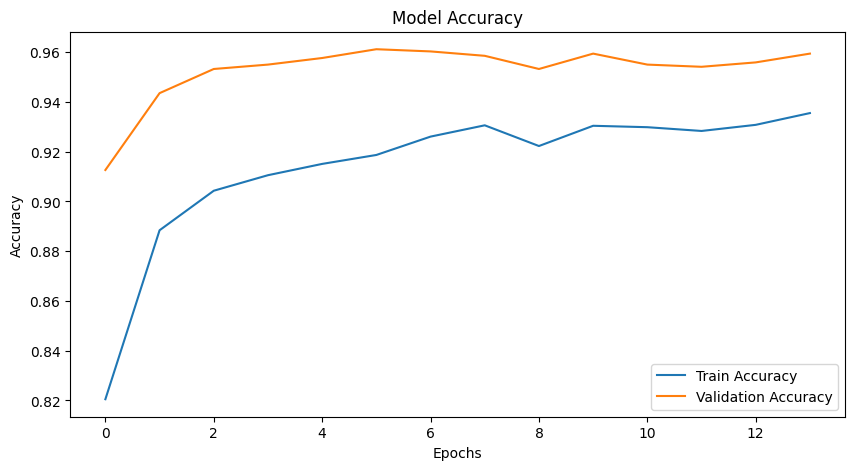

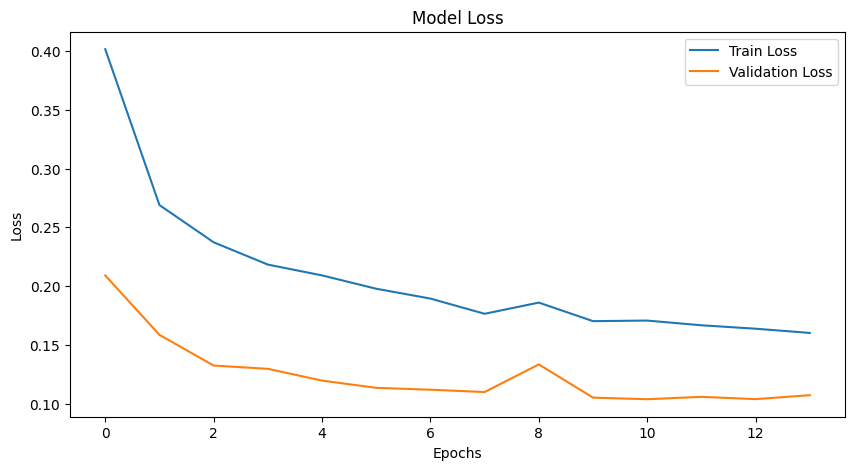

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


36/36 [==============================] - 38s 1s/step - loss: 0.1051 - accuracy: 0.9620
Test Accuracy: 96.20%


In [ ]:
model.save('mask_detector_model.h5')

NameError: name 'model' is not defined

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def preprocess_image(image_path, target_size=(128, 128)):
    # Load the image
    image = load_img(image_path, target_size=target_size)
    
    # Convert the image to a NumPy array
    image_array = img_to_array(image)
    
    # Normalize the image (if your model was trained with rescaled images)
    image_array = image_array / 255.0
    
    # Add a batch dimension (for prediction)
    image_array = np.expand_dims(image_array, axis=0)
    
    return image_array

model = tf.keras.models.load_model('mask_detector_model.h5')

# Path to the test image
image_path = r'C:\Users\ACER\OneDrive\Pictures\picture_with_id.jpeg' 

# Preprocess the image
processed_image = preprocess_image(image_path)

# Make a prediction
prediction = model.predict(processed_image)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print(f"{prediction[0][0]} Without Mask")
else:
    print(f"{prediction[0][0]} With Mask")

print(prediction[0][0])


1/1 [==============================] - 0s 209ms/step
0.9113709926605225 Without Mask
0.911371
